<a href="https://colab.research.google.com/github/you444Mo/Python-Projects/blob/main/GEN_BUS_740_Week_7_Assignment6_RD_DID_Moreimi_Zachary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GB 740 Assignment 6 - DID and RD

### PART 1: DID
In this week's lab, we worked with hotel spending data to assess the impact of the Eras tour on the hotel industry.



For this assignment, you will produce your own version of a difference-in-difference analysis of the Eras tour impact, using the same data we used in class.





In [2]:
# 1. preliminaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

# load the data
url = 'https://raw.githubusercontent.com/dansacks/gb740/refs/heads/main/hotel_spend.csv'
data = pd.read_csv(url)



In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cbsa_code         2600 non-null   int64  
 1   metro             2600 non-null   object 
 2   total_spend       2600 non-null   float64
 3   date              2600 non-null   object 
 4   week_num          2600 non-null   int64  
 5   concert_week_num  1144 non-null   float64
 6   concert_date      1144 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 142.3+ KB


In [4]:
data.describe()

,cbsa_code,total_spend,week_num,concert_week_num
count,2600.000000,2600.000000,2600.000000,1144.000000
mean,30743.400000,158517.722483,26.500000,28.045455
std,10646.092545,128308.408037,15.011218,21.942294
min,12060.000000,6380.171400,1.000000,11.000000
25%,19740.000000,61341.389750,13.750000,17.000000
50%,33220.000000,125766.830000,26.500000,22.500000
75%,40060.000000,212381.647500,39.250000,28.000000
max,47900.000000,841859.060000,52.000000,96.000000


In [5]:
data.head()

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,cbsa_code,metro,total_spend,date,week_num,concert_week_num,concert_date
0,12420,"Austin-Round Rock-San Marcos, TX",119593.610,03jan2023,1,NaN,NaN
1,12420,"Austin-Round Rock-San Marcos, TX",97870.724,10jan2023,2,NaN,NaN
2,12420,"Austin-Round Rock-San Marcos, TX",141958.480,17jan2023,3,NaN,NaN
3,12420,"Austin-Round Rock-San Marcos, TX",103286.650,24jan2023,4,NaN,NaN
4,12420,"Austin-Round Rock-San Marcos, TX",114396.690,31jan2023,5,NaN,NaN


## Question 1
Design a difference-in-differences analysis. Specifically, select from the list of metro areas (see canvas or [here](https://raw.githubusercontent.com/dansacks/gb740/refs/heads/main/top50_metros_dates.csv)) a metro area for your "treated" area and a metro area for your "control" area that you think would be appropriate for the analysis. Do not pick Pittsburgh or St. Louis. Explain why you chose them, taking care to explain at a conceptual level why you expect your control area to be appropriate. Explain what is the "pre" period and what is the "post" period.



### 1.a
#### What are yout treated and control metros?

Treated: Phoenix

Control: San Diego


### 1.b   
#### Explain why you chose them, taking care to explain at a conceptual level why you expect your control area to be appropriate



Phoenix and San Diego are both large, modern Metro areas in the southwest US that are also popular travel destinations. Both these areas have very sunny climates, and there is typically heightened tourism in the Winter and Summer Months. Many events other than the Eras tour (Sports/Concerts) take place in both cities over the year, making a good case for the parallel trends assumption to hold (ie: absent the Eras Tour, Pheonix would behave similarly to San Diego in terms of regional hotel spend). Due to these similarities, I believe that Pheonix (treatment) and San Diego (Control) make plausible subjects for this analysis.

### 1.c.
#### Explain what is the "pre" period and the "post" or "treated" period.




The pre period will be the previous 3 weeks to tour week (based on the tour week in Pheonix) for both treatment and control. Since the tour occurs on week 11 in the Pheonix area, we will use the previous 3 weeks in the pre-period (weeks 8-10) for both Pheonix (treatment) and San Diego (Control). The post (treated) period will be the tour week in the Pheonix area (week 11) for both Pheonix (treatment) and San Diego (control).

## Question 2

Find the mean of the outcome metric in your treated and control areas, in the pre period and in the concert period. What is the simple DID estimate?


In [6]:
### Take to Log of Spend to smooth out skewness
data['log_spend'] = np.log(data['total_spend'])

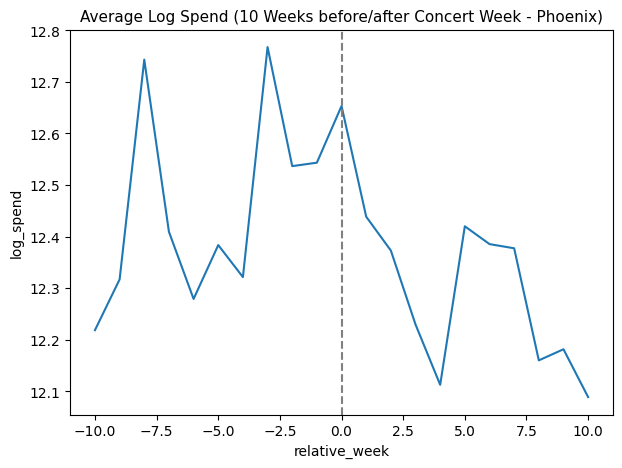

In [7]:
### Create a "Relative Date" Field in regards to weeks away from concert week
data['relative_week'] = data['week_num'] - data['concert_week_num']

# Grab Phoenix Data
Phoenix_Data = data.query("cbsa_code == 38060")

data_agg = Phoenix_Data.groupby('relative_week')['log_spend'].mean().reset_index()

# B. plot
plt.figure(figsize = (7,5))

sns.lineplot(
    data = data_agg.query("relative_week.between(-10,10)"), ### Query to only between -10,10 relative dates
    x = 'relative_week',
    y = 'log_spend'
)

### Add a vertical line during tour week
plt.axvline(0, linestyle = '--', color = 'grey')

plt.title("Average Log Spend (10 Weeks before/after Concert Week - Phoenix)", fontsize = 11)

plt.show()


 **<u>Prelimenary Observations:</u>**

There's a noticeable spike in average log_spend at relative_week = 0 (Tour Week) compared to other weeks in the vicinity for Phoenix. In the 10 weeks following concert week, we notice a huge dip in avg log_spend.

In [8]:
### DID using Last 3 weeks before treatment as pre period, and concert week as the post period

### Grab Needed Rows for Treatment Group and Control Group
# Treatment
Phoenix_Post_Period = data.query("cbsa_code == 38060 and week_num == 11")['log_spend'].iloc[0]
Phoenix_Pre_Period = data.query("cbsa_code == 38060 and week_num.between(8,10)")['log_spend'].mean()

print(f"Treatment Post Outcome: {Phoenix_Post_Period}")
print(f"Treatment Pre Outcome: {Phoenix_Pre_Period}")
print()

# Control
SanDiego_Post_Period = data.query("cbsa_code == 41740 and week_num == 11")['log_spend'].iloc[0]
SanDiego_Pre_Period = data.query("cbsa_code == 41740 and week_num.between(8,10)")['log_spend'].mean()

print(f"Control Post Outcome: {SanDiego_Post_Period}")
print(f"Control Pre Outcome: {SanDiego_Pre_Period}")
print()

# Calculate Differences Per Each Group
Treat_Diff = Phoenix_Post_Period - Phoenix_Pre_Period
Control_Diff = SanDiego_Post_Period - SanDiego_Pre_Period
# Calculate Differnece in Differences
DID = Treat_Diff - Control_Diff


print(f"Treatment Difference: {Treat_Diff}")
print(f"Control Difference: {Control_Diff}")
print()
print(f"Difference in Differences on Log Spending: {DID}")





Treatment Post Outcome: 12.653216564986197
Treatment Pre Outcome: 12.615734168943431

Control Post Outcome: 11.694539521544916
Control Pre Outcome: 11.501824770443726

Treatment Difference: 0.03748239604276549
Control Difference: 0.19271475110119063

Difference in Differences on Log Spending: -0.15523235505842514


### Explain in words what this estimate means

Based one our estimated, where we classified the "pre" period as the 3 weeks before the Eras Tour event (weeks 8-10), and the "post" period as the tour event week (week 11): The negative DiD estimate implies that, relative to San Diego, Phoenix experienced a smaller increase in regional hotel spending during the Eras Tour week, amounting to approximately a 15.5% lower change compared to the control group.

## Question 3

Estimate the DID model by regression.

In [46]:
### Using Weeks 8-11 (Phoenix and San Diego)

# A. Make post and treat indicators
data['post'] = (data['week_num'] == 11).astype(int)
data['treat'] = (data['cbsa_code'] == 38060).astype(int)

# B. estimate
est_data = data.query("cbsa_code.isin([38060,41740]) and week_num.between(8,11)") ### Pitt and St. Louis

did_formula = 'log_spend ~ post + treat + post:treat' ### : tells statsmodels to create interaction term
did_model = smf.ols(formula = did_formula, data = est_data).fit()
print(did_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_spend   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     32.06
Date:                Wed, 17 Dec 2025   Prob (F-statistic):            0.00295
Time:                        06:30:15   Log-Likelihood:                 6.2839
No. Observations:                   8   AIC:                            -4.568
Df Residuals:                       4   BIC:                            -4.250
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5018      0.090    127.698      0.0

**<u>Observations:</u>**

DID: -0.1552

Based one our model, we once again achieve a DiD of -0.1552, indicating that Phoenix experience a 15.52% smaller increase in hotel revenue during the Eras tour versus that of the control group (San Diego) during the same timeframe. It should be noted, however, that the associated p-value with the DiD estimate is 0.575, indicating that our estimate is not statistically significant.

Fixed Effected Model (accounting for all weeks)

In [49]:
### Fixed Effect Model
ps_data = data.query("cbsa_code.isin([38060, 41740])").copy()

ps_data["post"]  = (ps_data["week_num"] == 11).astype(int) ### Post period is week 11 (Eras Tour Week in Pheonix)
ps_data["treat"] = (ps_data["cbsa_code"] == 38060).astype(int) ### Treatment Group is Phoenix

### Show interaction only for Phoenix and San Diego
formula = "log_spend ~ post:treat + C(week_num) + C(cbsa_code)"
model = smf.ols(formula=formula, data=ps_data).fit(cov_type="HC1")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_spend   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     66.64
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           6.00e-33
Time:                        06:31:46   Log-Likelihood:                 29.000
No. Observations:                 104   AIC:                             50.00
Df Residuals:                      50   BIC:                             192.8
Df Model:                          53                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.11

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 53, but rank is 52


**<u>Observations:</u>**

post:treat DiD: 0.3007

This fixed-effect model attempts to show if Phoenix’s hotel spending during Eras tour week is significantly different from any week compared to the control group (San Diego). We see that Phoenix's hotel spend was about 30% higher than San Diego’s relative to their usual difference during the Eras Tour week, controlling for week-specific variance.

## Question 4
4.a: What assumptions does your DID model require?

Both DID models require that we satisfy the "parallel trends" assumption, stating that "absent the Eras Tour, Pheonix would behave similarly to San Diego in terms of regional hotel spend." The Fixed effect model further relies on this assumption by expaning our analysis across all weeks, rather than 3 weeks prior.

4.b: Provide evidence to assess that assumption,

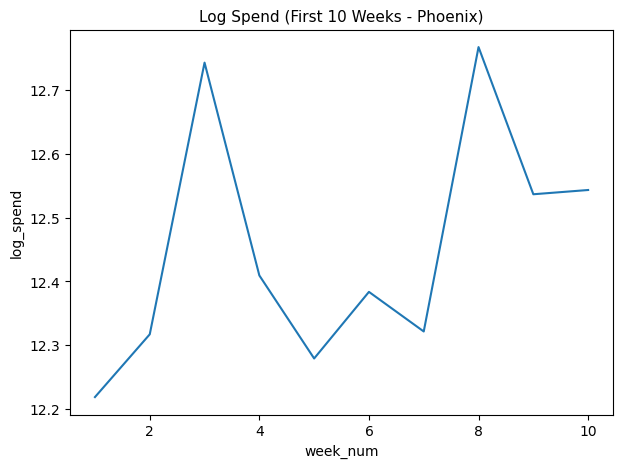

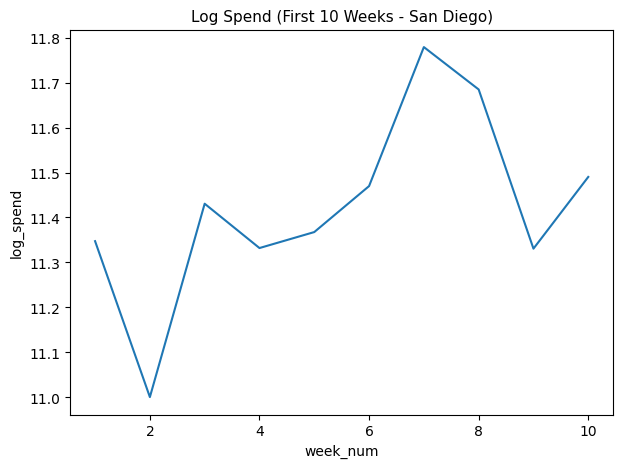

In [51]:
# Phoenix Data
plt.figure(figsize = (7,5))

sns.lineplot(
    data = Phoenix_Data.query("week_num.between(1,10)"), ### Query to only between -10,10 relative dates
    x = 'week_num',
    y = 'log_spend'
)

### Add a vertical line during tour week

plt.title("Log Spend (First 10 Weeks - Phoenix)", fontsize = 11)

plt.show()

print()

# San Diego Data
SanDiego_Data = data.query("cbsa_code == 41740")


plt.figure(figsize = (7,5))

sns.lineplot(
    data = SanDiego_Data.query("week_num.between(1,10)"), ### Query to only between -10,10 relative dates
    x = 'week_num',
    y = 'log_spend'
)

### Add a vertical line during tour week

plt.title("Log Spend (First 10 Weeks - San Diego)", fontsize = 11)

plt.show()

 **<u>Observations:</u>**

 Weeks 1-10 for both Phoenix and San Diego generally display similar trends with occasional spikes in terms of log hotel spend. Because of this, we don't observe any systematic divergence between the two groups. We also notice that both groups exhibit a positive slope as we move further towards weeks 8-10 (again noting the volatility between the two groups in early weeks).

## Question 5

What conclusions can you draw, if any, from this analysis?


Analyzing the non-fixed effect analysis setup, even though we produced a DiD effect size of -15.52%, we cannot say with statistical certainty that Eras Tour week in Phoenix lead to a higher or lower percent change in Total Hotel Spend relative to the control group (San Diego) during the same timeframe.

When analyzing the fixed effect model (expanded to all weeks rather than just looking at 4 total weeks), we estimate a statistically significant DiD of 0.3007, indicating that Phoenix's hotel spend was about 30% higher than San Diego’s relative to their usual difference during the Eras Tour week, controlling for week-specific variance.

From this analysis, we gather that this specific comparision is sensitive to the analysis window selected. While the event-week comparison does not yield a statistically significant effect, the fixed-effects model provides evidence that Phoenix exhibited unusually high hotel spending during the concert week relative to its historical relationship with the control city (San Diego).

## PART 2: RD

You will use regression discontinuity to estimate the effect of default suggestion (dollar vs. percent) on the tipping rate, defined as the % of the fare left as a tip.  

To speed up computation, you may want to aggregate to the mean of the variables, by fare.


In [12]:
# run only once per session
!pip install rdrobust
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from rdrobust import rdrobust, rdplot

In [13]:
# preliminaries
url = 'https://raw.githubusercontent.com/dansacks/gb740/main/tips.csv'
data_fare = pd.read_csv(url)

# you may want to aggregate the data to the means by fare

* Fare: Amount charged (Scoring Variable) (treatment (x))
* Tip: tip left, in dollars (outcome - y)
* Ride_duration: Trip length in minutes
* Distance: Distance travelled in miles
* Pkp_day: Day of pick up (0= Sunday, 1=Monday etc.)

In [14]:
data_fare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723682 entries, 0 to 723681
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare             723682 non-null  float64
 1   tip              723682 non-null  float64
 2   ride_duration    723682 non-null  int64  
 3   distance         723682 non-null  float64
 4   passenger_count  723682 non-null  int64  
 5   day              723682 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 33.1 MB


In [15]:
data_fare.describe()

,fare,tip,ride_duration,distance,passenger_count,day
count,723682.000000,723682.000000,723682.000000,723682.000000,723682.000000,723682.000000
mean,9.633489,1.892067,12.698905,2.517955,1.991050,3.147376
std,5.025429,1.339272,7.524620,2.104988,1.556486,1.971762
min,2.900000,0.000000,1.000000,0.010000,1.000000,0.000000
25%,6.100000,1.000000,7.000000,1.180000,1.000000,2.000000
50%,8.500000,2.000000,11.000000,1.890000,1.000000,3.000000
75%,11.700000,2.000000,16.000000,3.080000,2.000000,5.000000
max,39.700000,100.000000,164.000000,18.620000,7.000000,6.000000


In [16]:
data_fare.head()

,fare,tip,ride_duration,distance,passenger_count,day
0,2.9,0.25,2,0.25,1,2
1,2.9,1.00,2,0.28,5,6
2,2.9,1.00,2,0.28,1,3
3,2.9,0.50,1,0.29,1,6
4,2.9,0.50,2,0.16,1,5


In [17]:
### Create variable for each day of week
Day_Dummies = pd.get_dummies(
    data_fare['day'],
    dtype = int
)

### Merge dummy fields with orginal DF
DataFareWDummies = pd.concat([data_fare.drop(columns = ['day']),Day_Dummies], axis = 1)

### Rename Dummy Field Columns
DataFareWDummies = DataFareWDummies.rename(columns = {
    0 : 'Sunday',
    1 : 'Monday',
    2 : 'Tuesday',
    3 : 'Wednesday',
    4 : 'Thursday',
    5 : 'Friday',
    6 : 'Saturday'
})

DataFareWDummies.head()

,fare,tip,ride_duration,distance,passenger_count,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2.9,0.25,2,0.25,1,0,0,1,0,0,0,0
1,2.9,1.00,2,0.28,5,0,0,0,0,0,0,1
2,2.9,1.00,2,0.28,1,0,0,0,1,0,0,0
3,2.9,0.50,1,0.29,1,0,0,0,0,0,0,1
4,2.9,0.50,2,0.16,1,0,0,0,0,0,1,0


In [18]:
### Round Fair Amounts down to nearest integer
binsize = 1 ### 1 percentage point bin within margin of victory (common in practice)
DataFareWDummies['fare_rounded'] =  (DataFareWDummies['fare'] // binsize) * binsize

In [29]:
### Create % Default on Tip Amt Variable
DataFareWDummies['Tip_Percent'] = DataFareWDummies['tip'] / DataFareWDummies['fare']

### Agg Data to Fare Level
data_fare_agg = DataFareWDummies.groupby('fare_rounded').agg(
    {
        'tip' : 'mean',
        'Tip_Percent' : 'mean',
        'ride_duration' : 'mean',
        'distance' : 'mean',
        'passenger_count' : 'mean',
        'Sunday' : 'mean',
        'Monday' : 'mean',
        'Tuesday' : 'mean',
        'Wednesday' : 'mean',
        'Thursday' : 'mean',
        'Friday' : 'mean',
        'Saturday' : 'mean'

    }
).reset_index()

data_fare_agg.head()

,fare_rounded,tip,Tip_Percent,ride_duration,distance,passenger_count,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2.0,1.330263,0.458712,1.892325,0.262532,1.993127,0.113402,0.134021,0.148912,0.146621,0.152348,0.129439,0.175258
1,3.0,1.312992,0.367558,2.774511,0.484029,1.971796,0.138627,0.124068,0.149036,0.140456,0.148966,0.141792,0.157054
2,4.0,1.357162,0.298124,4.542217,0.778147,1.990418,0.134983,0.127076,0.145218,0.143784,0.152117,0.144423,0.152400
3,5.0,1.456079,0.264666,6.279759,1.049215,1.991767,0.134816,0.121235,0.149081,0.146983,0.152914,0.145234,0.149737
4,6.0,1.539019,0.237246,8.111080,1.346315,1.991678,0.130246,0.120488,0.147883,0.148215,0.156196,0.147800,0.149172


### Question 6:
Find  is the RDD estimate of the effect of the % default on tip amount?

In [30]:
# code for q6
print(rdrobust(y = data_fare_agg['Tip_Percent'], x = data_fare_agg['fare_rounded'], c= 15))

Call: rdrobust
Number of Observations:                    38
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations            13         25
Number of Unique Obs.             13         25
Number of Effective Obs.           5          6
Bandwidth Estimation           5.201      5.201
Bandwidth Bias                  8.01       8.01
rho (h/b)                      0.649      0.649

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        0.02    0.011     1.79   7.345e-02    [-0.002, 0.042]
Robust                 -        -    1.156   2.477e-01    [-0.012, 0.047]



**<u>Observations:</u>**

RDD estimate is 0.02

Crossing the $15 fair threshold and the default tip options moving from dollar amount to percentages is associated with a 2 percentage point increase to the average tipping rate. It should be noted the p-value of this effect size is 0.07345, meaning that this effect would be significant given a 10% significance level rather than a 5% alpha. At the 95% confidence level, we would not say that this effect size is significant.

### Question 7:
What assumption(s) does your estimate require for validity? Give an example of how those assumptions could go wrong.

One big assumption we make is that the scoring variable (fare amount) can't be manipulated around it's cuttoff threshold of $15. If taxi drivers purposely take longer routes in order to drive up fare prices and intice customers to tip more due to percentages being displayed as the default rather than whole dollar amounts, then we would say that the scoring variable "fare" is being manipulated, hence there being an implicit bias at the point of discontinuity. In this scenario, we would not be able to compare points near the cuttoff, and the discontinuity estimate would not be usefull as it would more so be reflective of taxi drivers manipulating trip prices to garner a different set of default tip options rather than the effect of the cuttoff threshold.  

Another assumption we make is that the discontinuity is purely being caused by x (in this case, the fair amount reaching the $15 threshhold). This could fail if "excludability" is violated and discontinuity in Tipping can be attribtued to other factors other than just hitting the fair threshold.

### Question 8
Provide and discuss  (a) that there really is an effect of tip default on tipping, and (b) that your RDD is valid? Your answer here should be a few plots, along with discussion of what the plots show and why they are informative.


Plotting RDD Chart on Outcome and Scoring Variable:

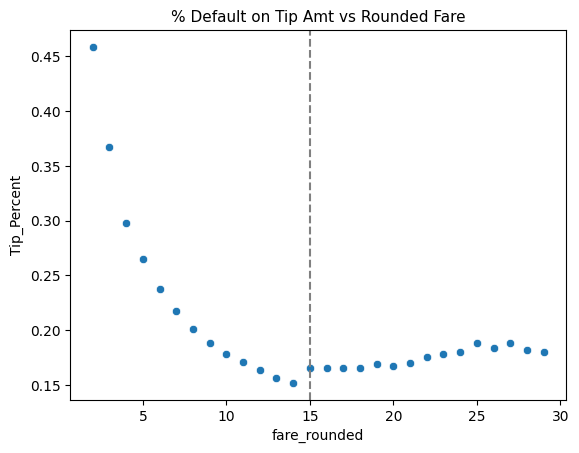

In [33]:
### Rounded RDD Plot (Narrowed)
bw = 30
data_narrow = data_fare_agg[np.abs(data_fare_agg['fare_rounded']) < bw]

sns.scatterplot(
    data = data_narrow,
    x = 'fare_rounded',
    y = 'Tip_Percent'
)

plt.axvline(15,color = 'grey', linestyle = '--', label = 'Scoring Variable Cuttoff')
plt.title('% Default on Tip Amt vs Rounded Fare', fontsize = 11)
plt.show()

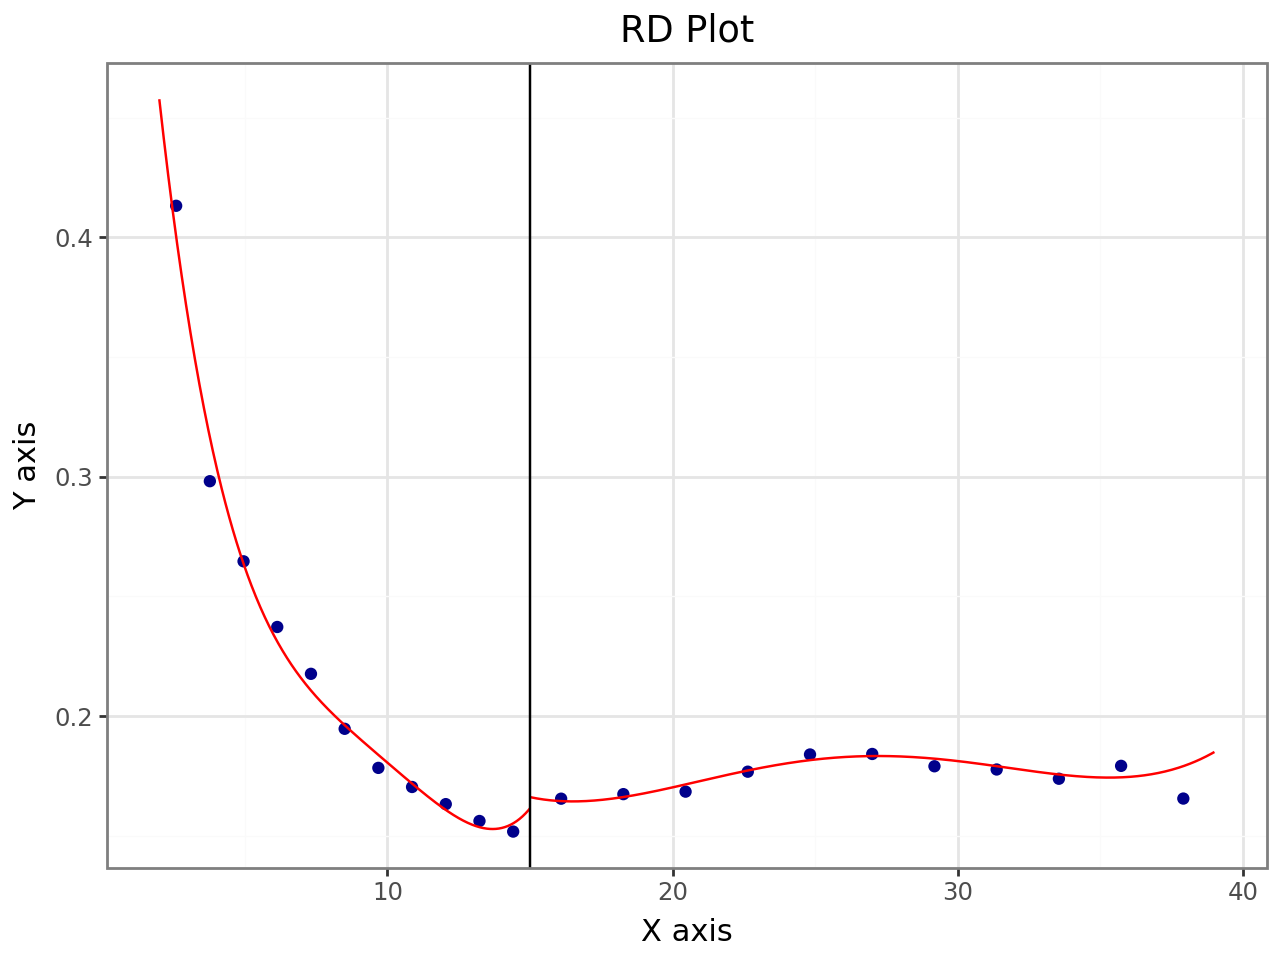

Call: rdplot
Number of Observations:                    38
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations            13         25
Number of Effective Obs           13         25
Bandwith poly. fit (h)          13.0       24.0
Number of bins scale               1          1
Bins Selected                     11         11
Average Bin Length             1.182      2.182
Median Bin Length              1.182      2.182
IMSE-optimal bins               11.0       11.0
Mimicking Variance bins         37.0       12.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [35]:
# RD Plot using rdrobust package
rdplot(y = data_fare_agg['Tip_Percent'], x = data_fare_agg['fare_rounded'], c= 15, binselect = 'es')

Notice the minor discontinuity (jump) that we see at the cuttoff point ($15).

In [37]:
rdrobust(y = data_fare_agg['Friday'], x = data_fare_agg['fare_rounded'], c = 15)

Call: rdrobust
Number of Observations:                    38
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations            13         25
Number of Unique Obs.             13         25
Number of Effective Obs.           5          6
Bandwidth Estimation           5.728      5.728
Bandwidth Bias                 8.388      8.388
rho (h/b)                      0.683      0.683

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.002    0.003    0.822   4.111e-01    [-0.003, 0.008]
Robust                 -        -    0.666   5.052e-01    [-0.004, 0.009]


Plotting RDD Chart on Covariates vs Scoring Variable:

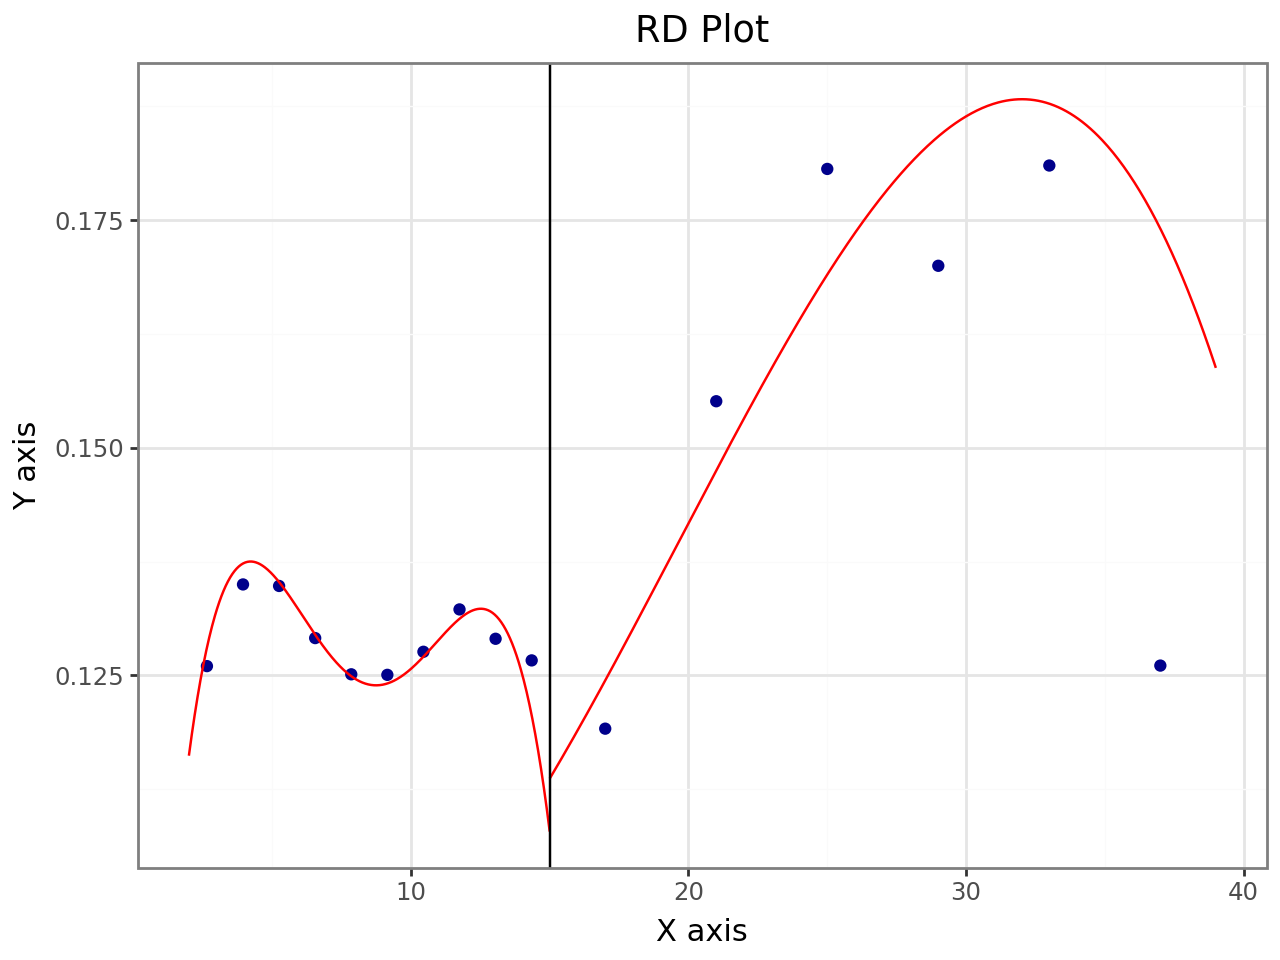

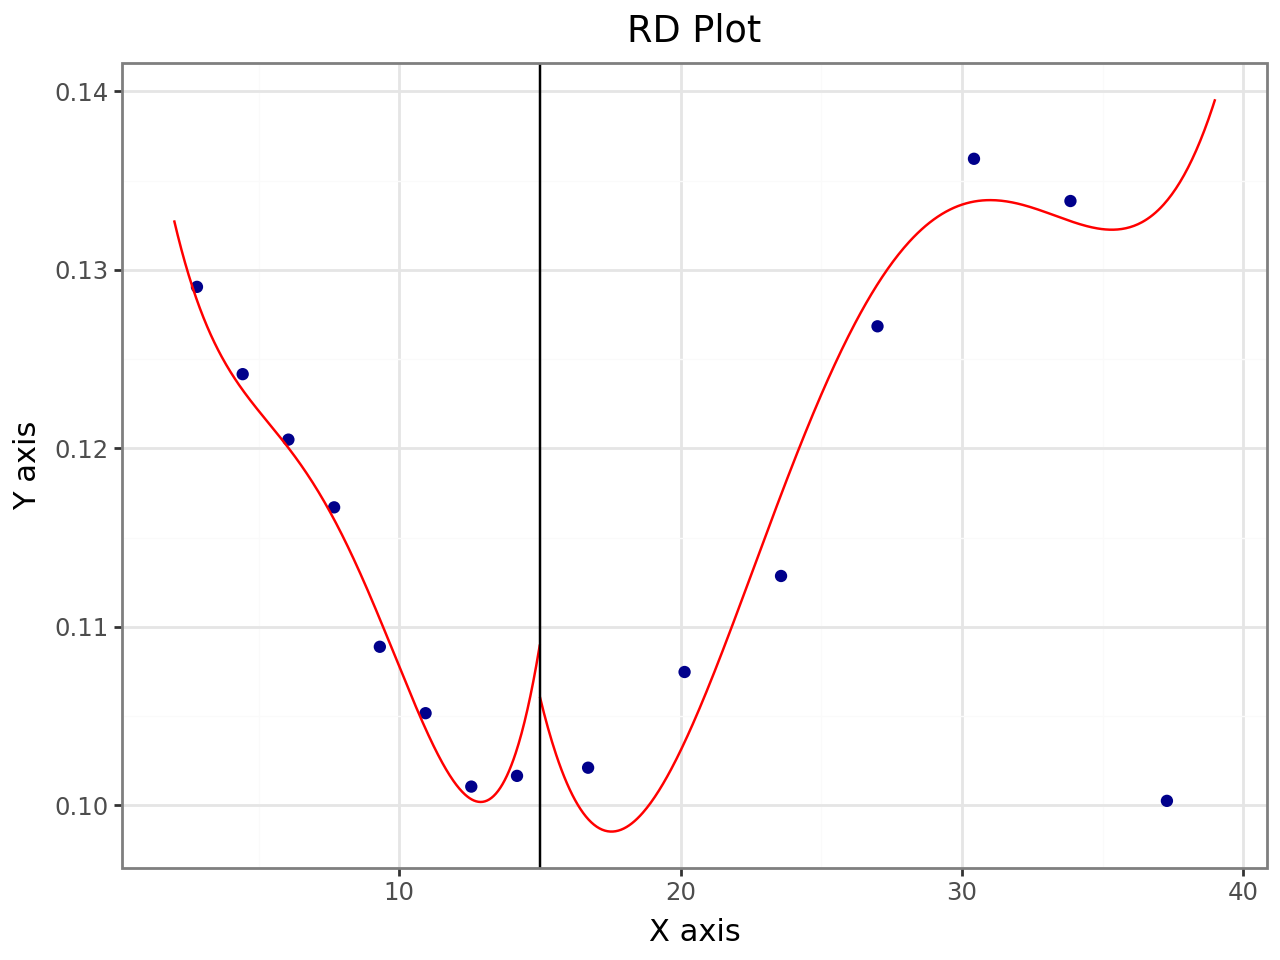

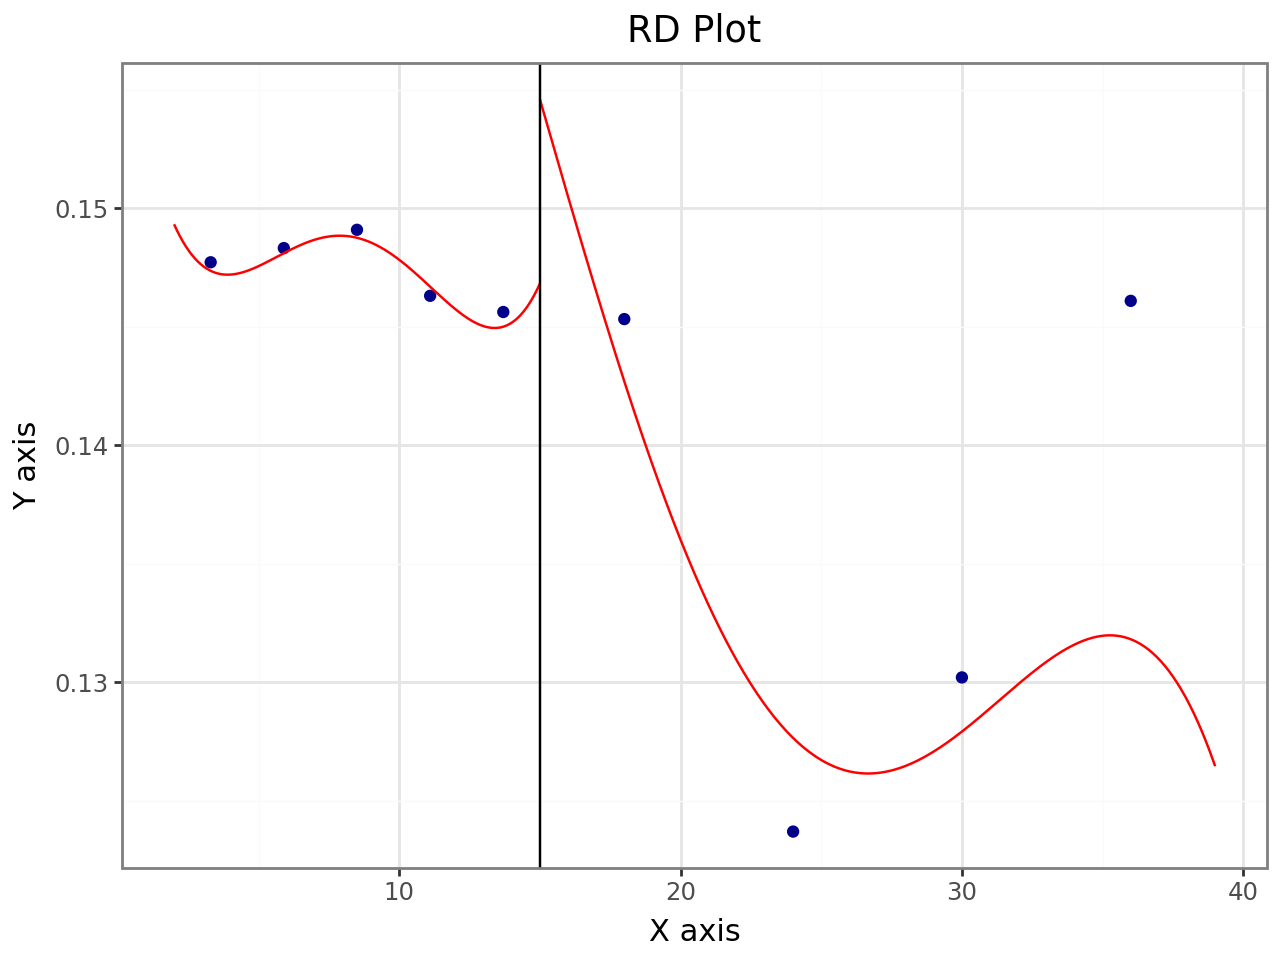

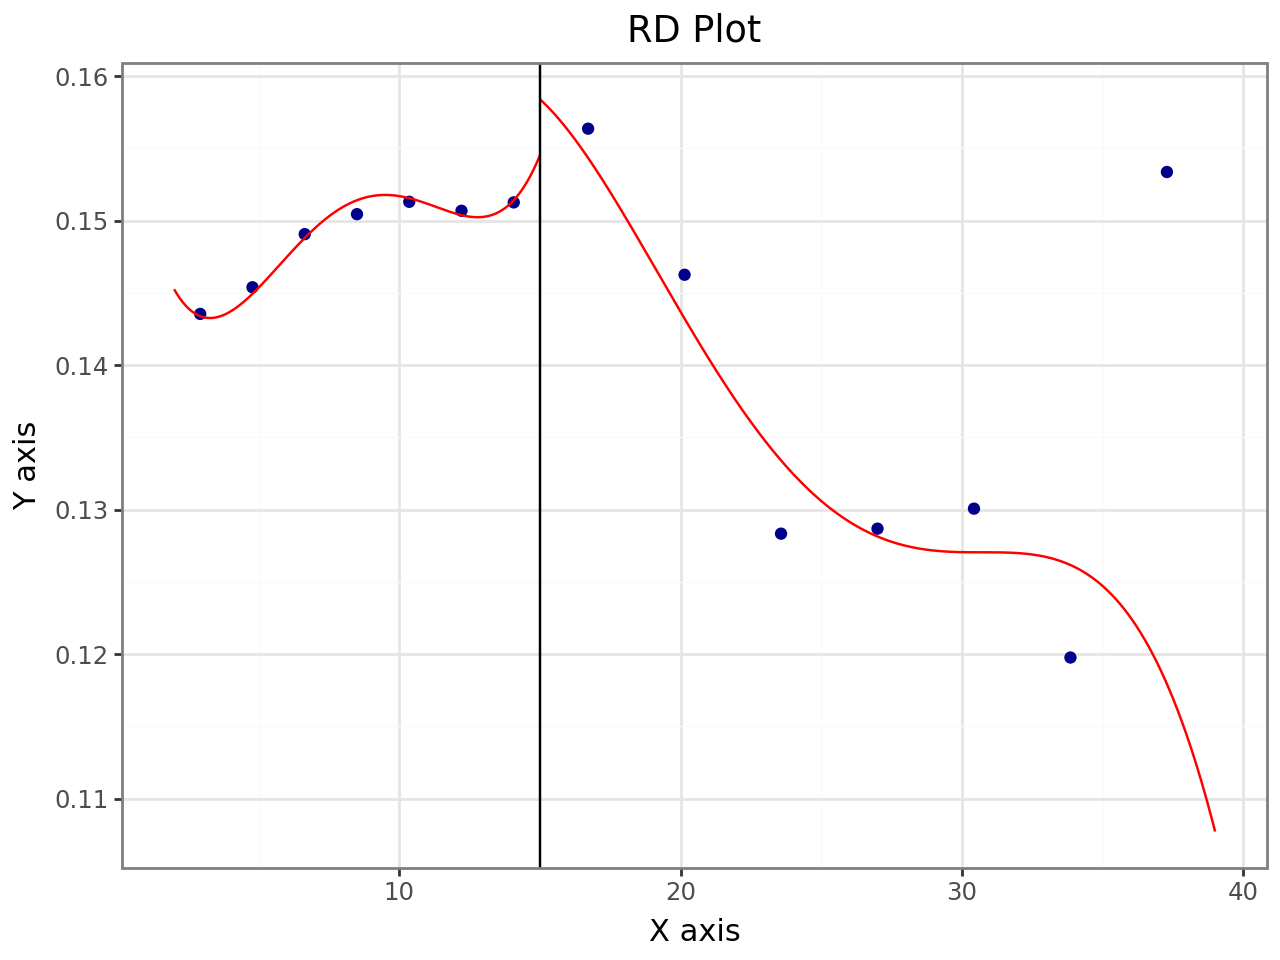

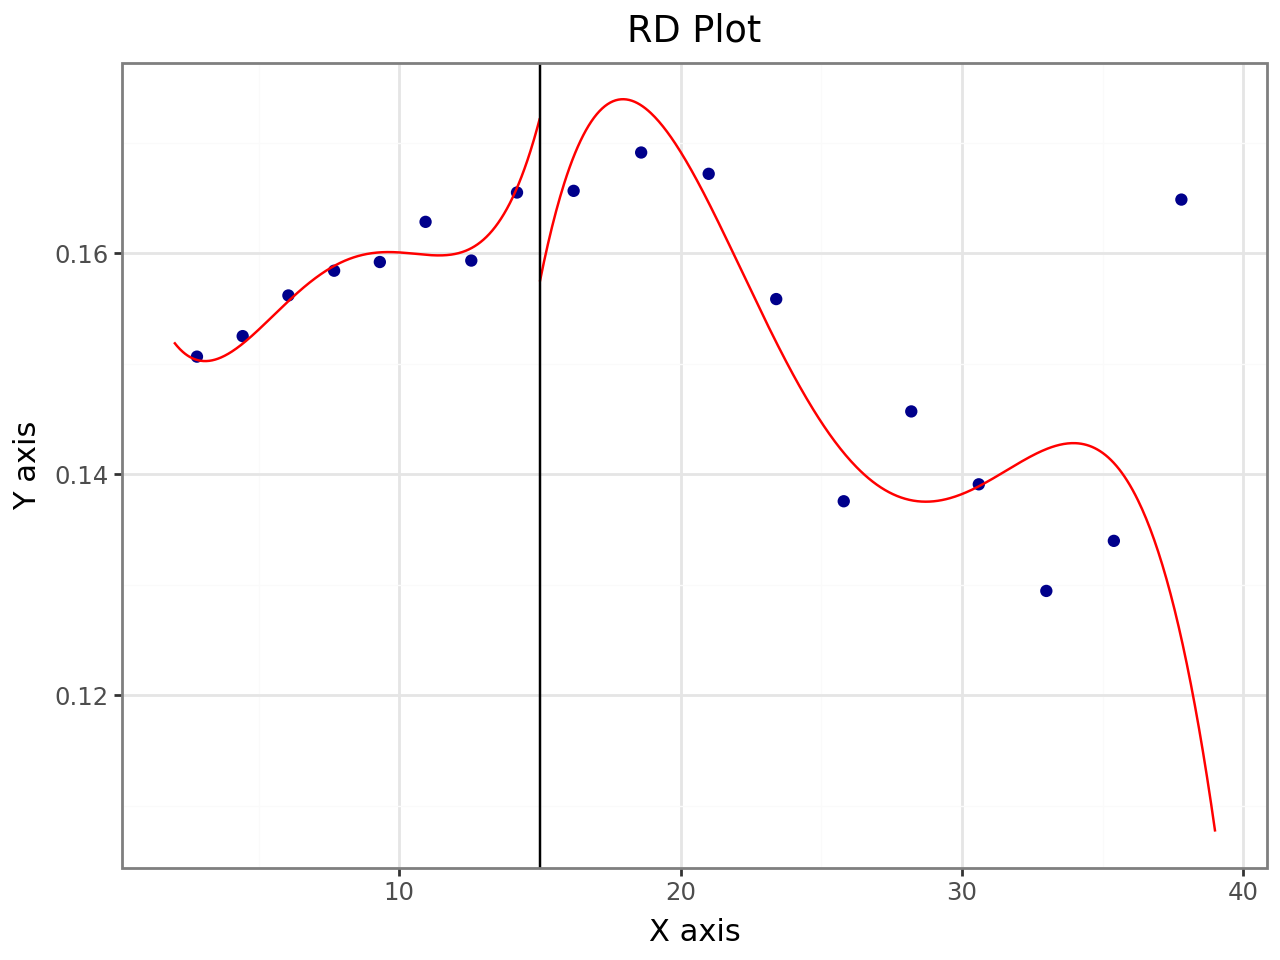

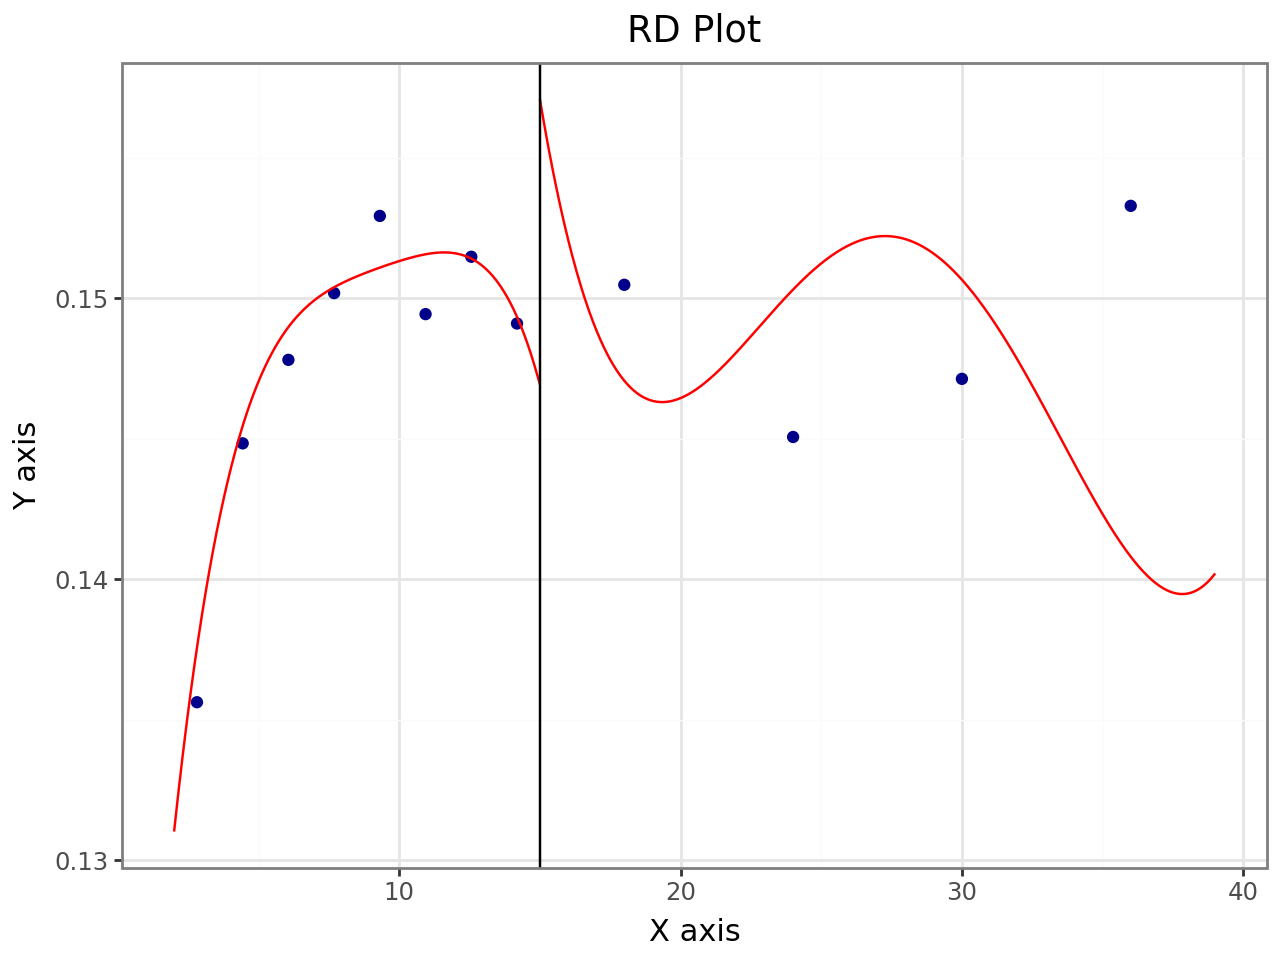

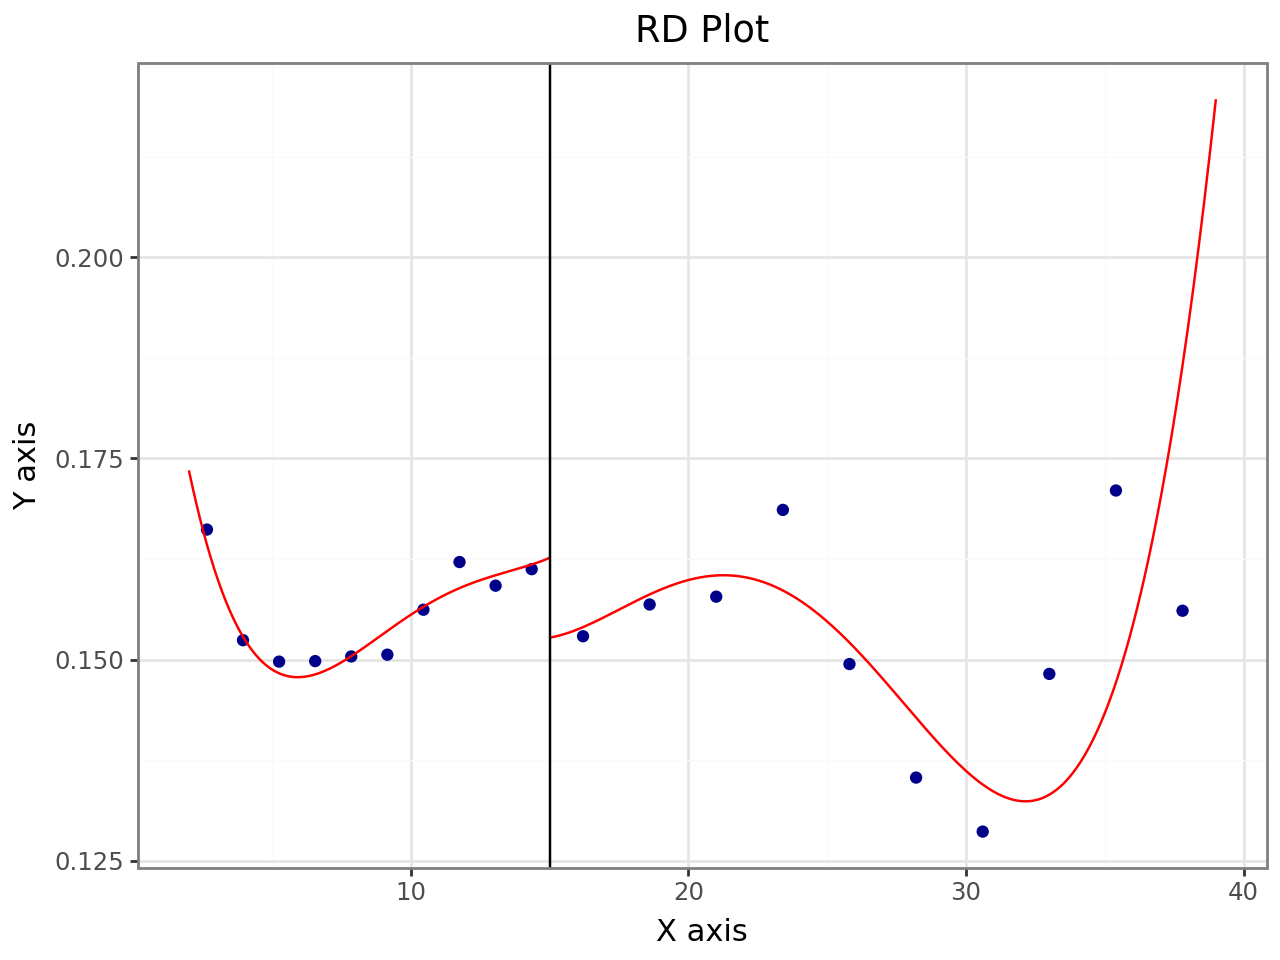

In [41]:
### Checking for jumps at cuttoff point for covariate (day of week)
days_of_week = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

for week in days_of_week:
  rdplot(y = data_fare_agg[week], x = data_fare_agg['fare_rounded'], c= 15, binselect = 'es')

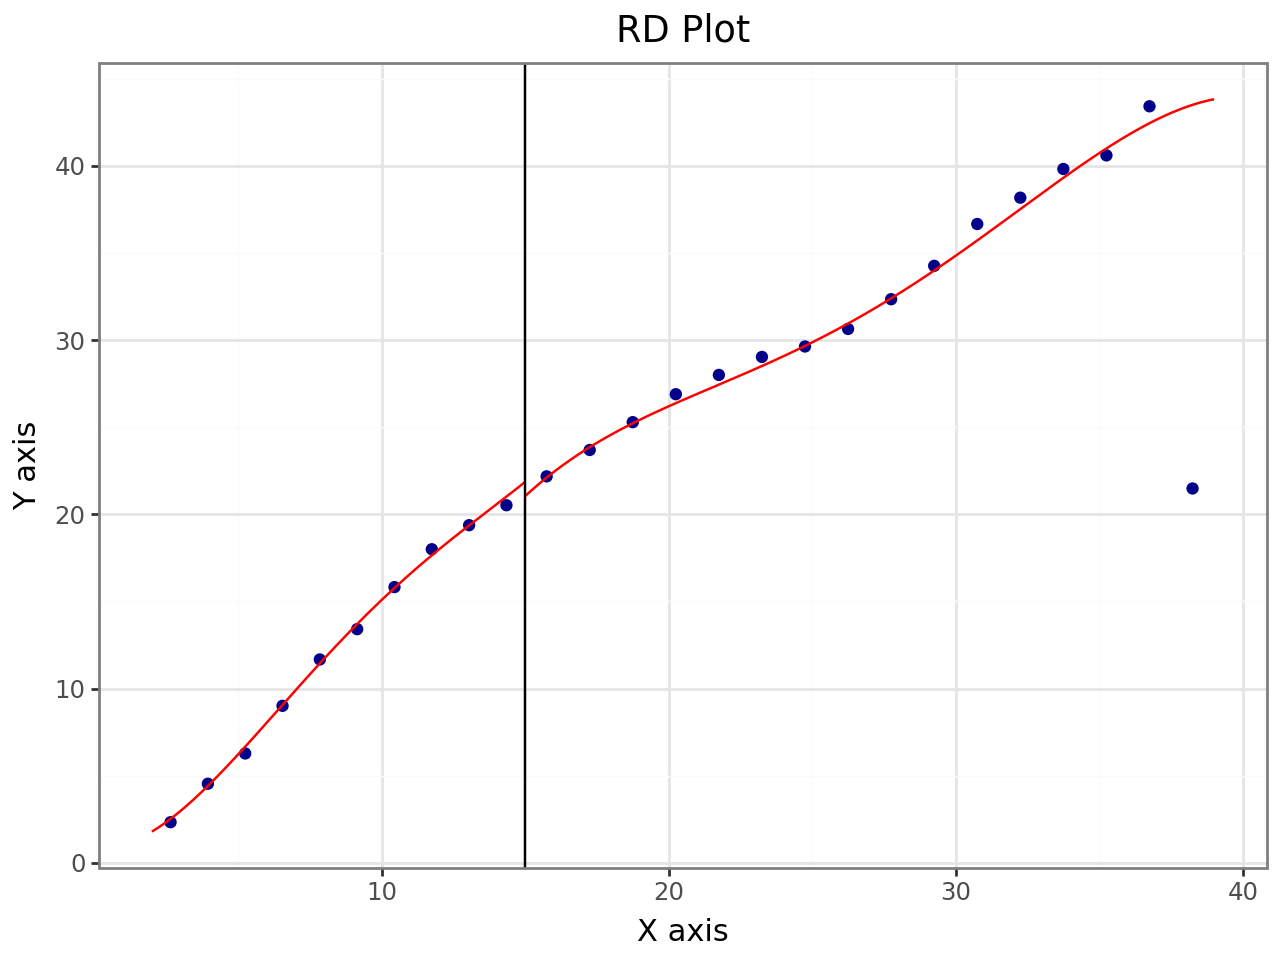

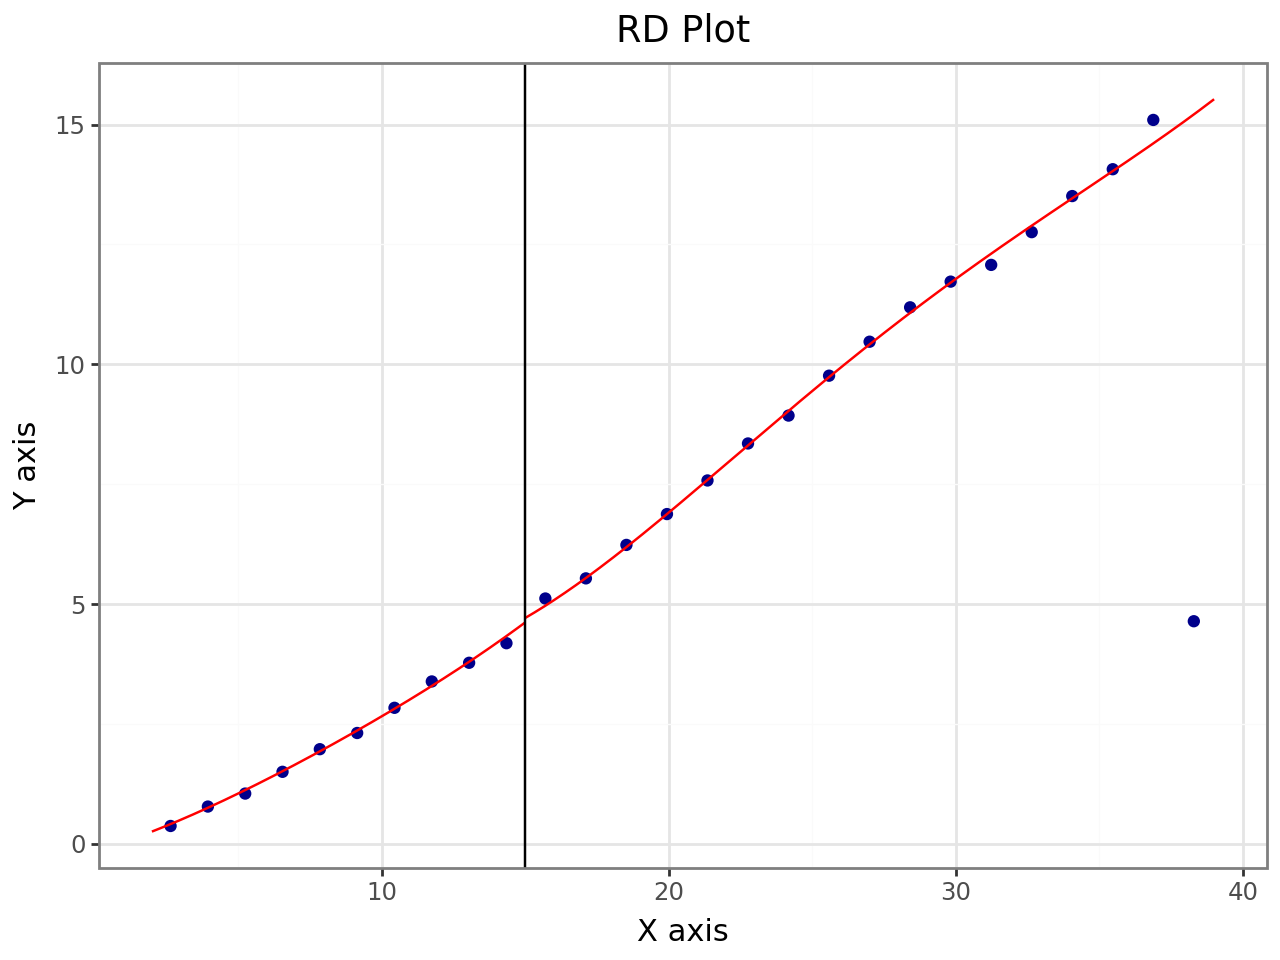

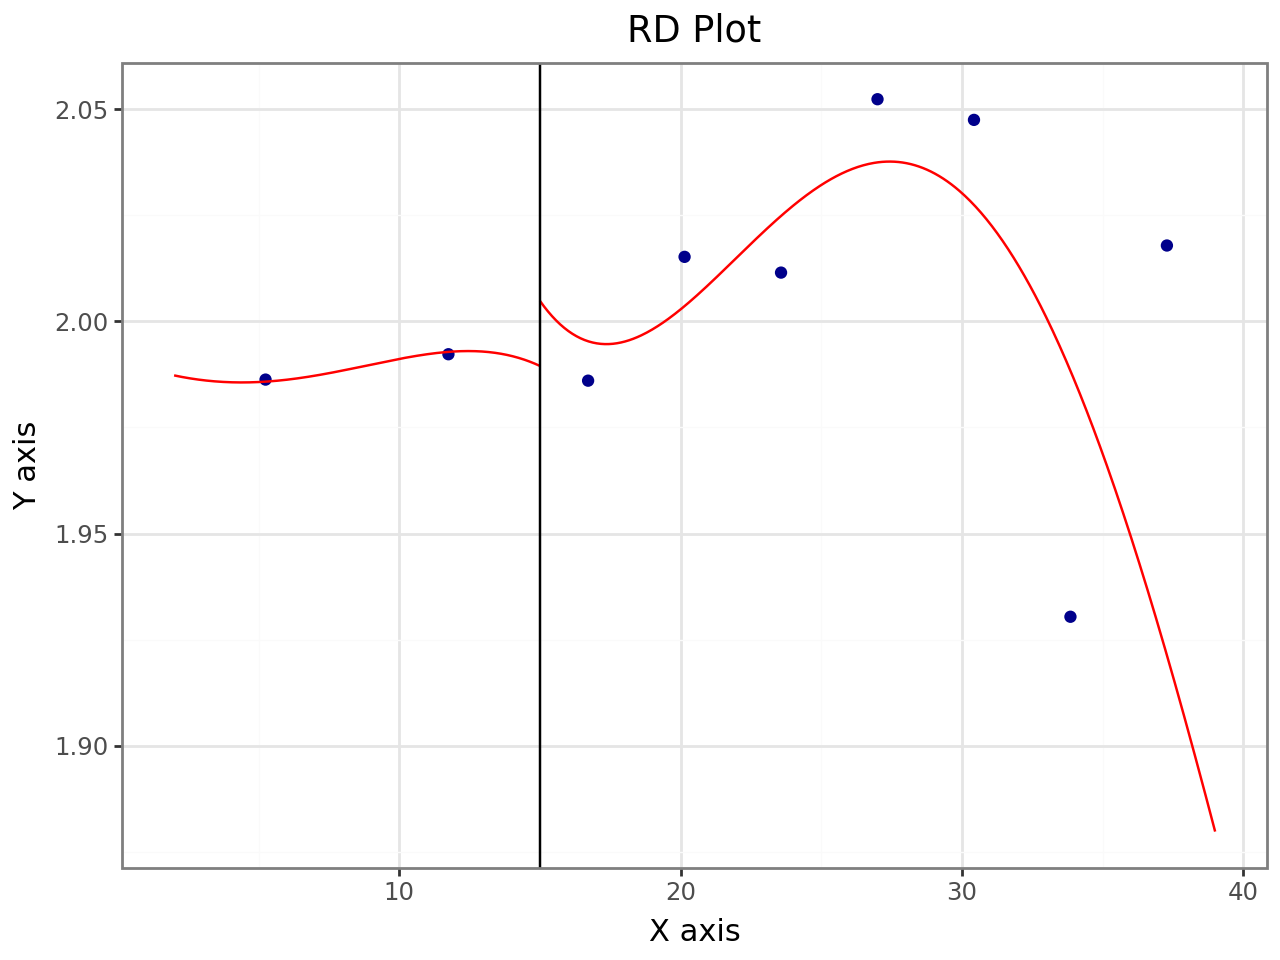

In [44]:
### Checking for jumps at cuttoff point for covariate (day of week)
Covariates = list(data_fare_agg[['ride_duration','distance','passenger_count']].columns)

for Covariate in Covariates:
  rdplot(y = data_fare_agg[Covariate], x = data_fare_agg['fare_rounded'], c= 15, binselect = 'es')

**<u>Observations:</u>**

The RDD plot on the outcome and scoring variable (tip_percent and fare_rounded) show a clear disconinuity at the cuttoff point: 15 dollars. The Discontinuity amount was estimated to be 0.02 (Crossing the $15 fare threshold and the default tip options moving from dollar amount to percentages is associated with a 2 percentage point increase to the average tipping rate). This value, however was found to not be statistically significant at the 5% significance level (p-value of 0.07345 and a confidence interval that includes 0), yet is marginally significant at the 10% level.

To check for validity, I plotted our covariates (days of week, ride duration, distance, etc...) against our scoring variable (fare price) to check for significant jumps at the cuttoff threshold (15 dollars). RDD requires that our covariates exibit smoothness along the cuttoff threshold and not exhibit any significant jumps. We see from checking against all days of the week as well as the other covariates that there is no signs of discontinuity. The covariates have relatively smooth trends around the cuttoff threshold.

What tip default would you recommend that a taxi company use? Explain.

Given that our p-value for the RDD estimate of 0.02 (2% increase in average tipping rate) at cutoff: $15 is > 0.05 but lower than < 0.10 (0.07345), I can't say with full confidence that I'd recommend the percentage default tipping method over the fixed dollar amount method, however, depending upon the organizations tolerance for false postitives, a case could potentially be made in favor of the % default method.

### Question 9
YES!!!